<a href="https://colab.research.google.com/github/yasinsoylu1997/bert/blob/main/BERT1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
#!pip install tensorflow-text
#!pip install tf-models-official

In [78]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

#for visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [79]:
dataset = pd.read_csv('hepsiburada.csv')
data=dataset[["yildizSayisi","yorum"]]
data=data[:20000]

In [80]:
data

,yildizSayisi,yorum
0,5,I bought this mouse for my home computer and i...
1,5,Ürünü yaklaşık 3 aydır kullanıyorum. Hem ergon...
2,5,"Teknolojiden çok anlayan biri değilim, sadece ..."
3,5,Perfect
4,5,"Ürünün yapısı oldukça ergonomik, işte kullanma..."
...,...,...
19995,4,İyi sayılır.
19996,4,Biraz yavaş
19997,2,** Bellek düşük takılma ve donma yaşanabiliyor...
19998,4,Mukemmel


In [81]:
dataset = pd.read_csv('hepsiburada.csv')
def sentiments(df):
  if df['yildizSayisi'] > 3.9:
    return 'Positive'
  elif df['yildizSayisi'] <= 3.0:
    return 'Negative'
data['sentiment'] = data.apply(sentiments, axis=1)

In [82]:
data

,yildizSayisi,yorum,sentiment
0,5,I bought this mouse for my home computer and i...,Positive
1,5,Ürünü yaklaşık 3 aydır kullanıyorum. Hem ergon...,Positive
2,5,"Teknolojiden çok anlayan biri değilim, sadece ...",Positive
3,5,Perfect,Positive
4,5,"Ürünün yapısı oldukça ergonomik, işte kullanma...",Positive
...,...,...,...
19995,4,İyi sayılır.,Positive
19996,4,Biraz yavaş,Positive
19997,2,** Bellek düşük takılma ve donma yaşanabiliyor...,Negative
19998,4,Mukemmel,Positive


In [83]:
data=data[["yorum","sentiment"]]

In [84]:
labeling = {
    'Positive':1, 
    'Negative':0
}

data['sentiment'] = data['sentiment'].apply(lambda x : labeling[x])
# Output first ten rows
data.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,yorum,sentiment
0,I bought this mouse for my home computer and i...,1
1,Ürünü yaklaşık 3 aydır kullanıyorum. Hem ergon...,1
2,"Teknolojiden çok anlayan biri değilim, sadece ...",1
3,Perfect,1
4,"Ürünün yapısı oldukça ergonomik, işte kullanma...",1
5,"Ürün beklendiği gibi, zaten Logitech fareleri ...",1
6,Ucuz markalara boşuna para vermeyin. Bu ürünü ...,1
7,"Ev kullanımı için harika ötesi, ben çok memnun...",1
8,Ürün bayan olarak benim elime tam oturuyor. Am...,1
9,Dandik bir mousetan sonra bunu kullanırsanız n...,1


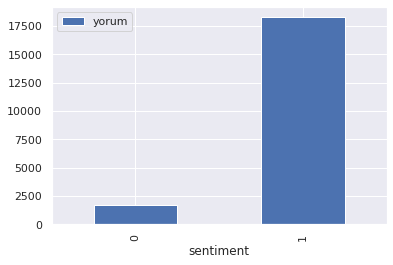

In [85]:
data.groupby('sentiment').count().plot(kind='bar')


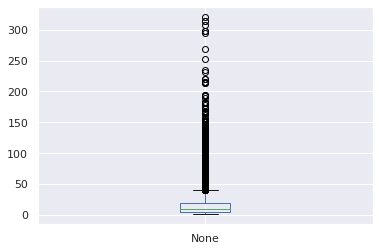

In [86]:
# Calculate review lengths
review_len = pd.Series([len(yorum.split()) for yorum	 in data['yorum']])

# The distribution of review text lengths
review_len.plot(kind='box')

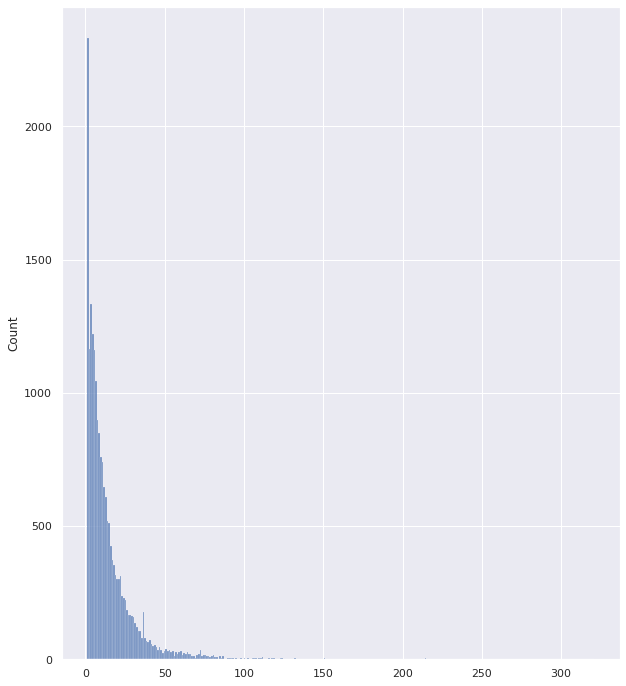

In [87]:
sns.set_theme(
    context='notebook',
    style='darkgrid',
    palette='deep',
    font='sans-serif',
    font_scale=1,
    color_codes=True,
    rc=None,
)

plt.figure(figsize = (10,12))
sns.histplot(review_len)

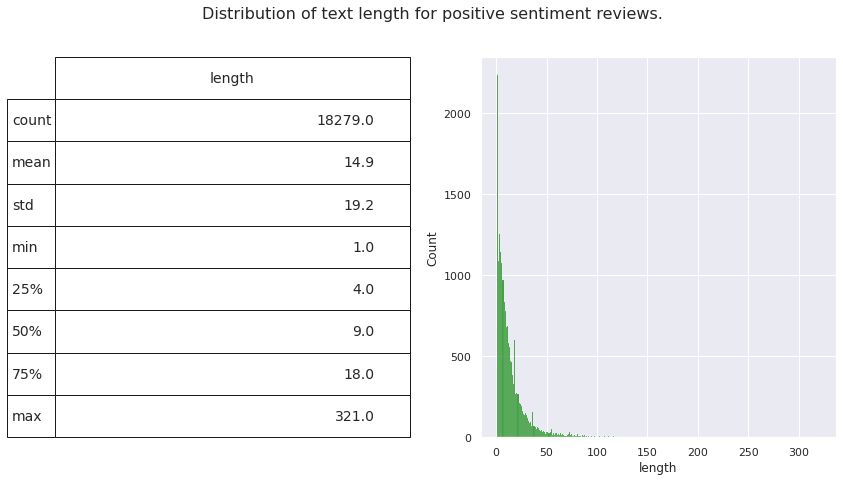

In [88]:
fig = plt.figure(figsize=(14,7))
data['length'] = data.yorum.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(data[data['sentiment']==1]['length'], ax=ax1,color='green')
describe = data.length[data.sentiment==1].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment reviews.', fontsize=16)

plt.show()

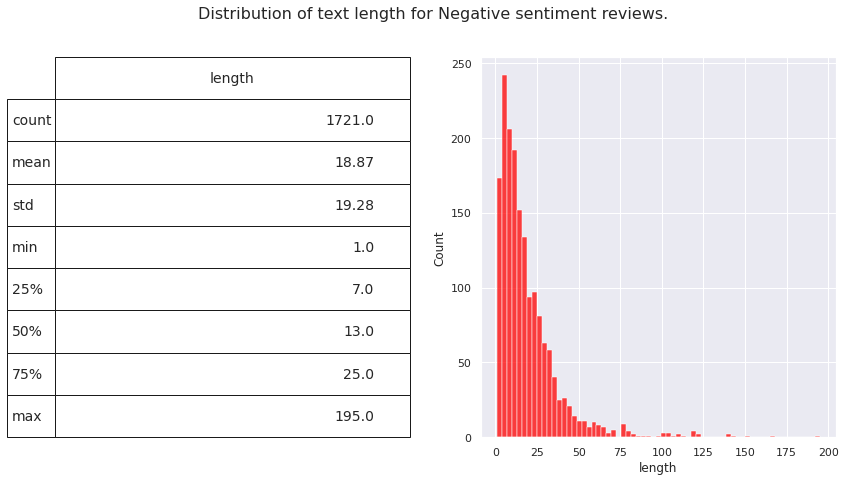

In [89]:
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(122)
sns.histplot(data[data['sentiment']==0]['length'], ax=ax1,color='red')
describe = data.length[data.sentiment==0].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Negative sentiment reviews.', fontsize=16)

plt.show()

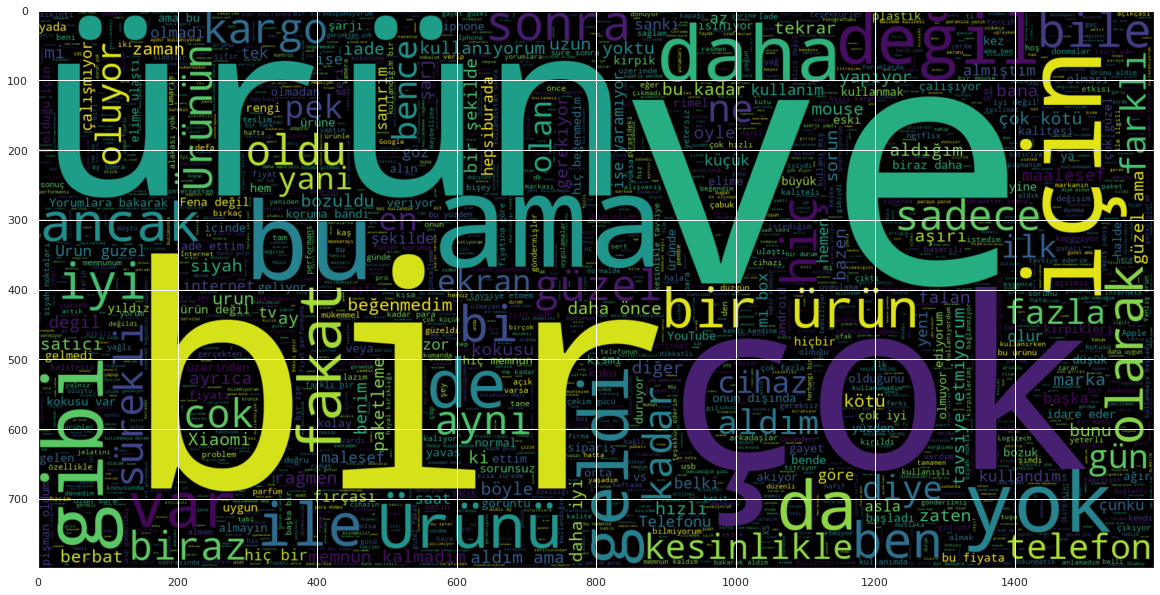

In [90]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) # Negative Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.sentiment == 0].yorum))
plt.imshow(wc , interpolation = 'bilinear')

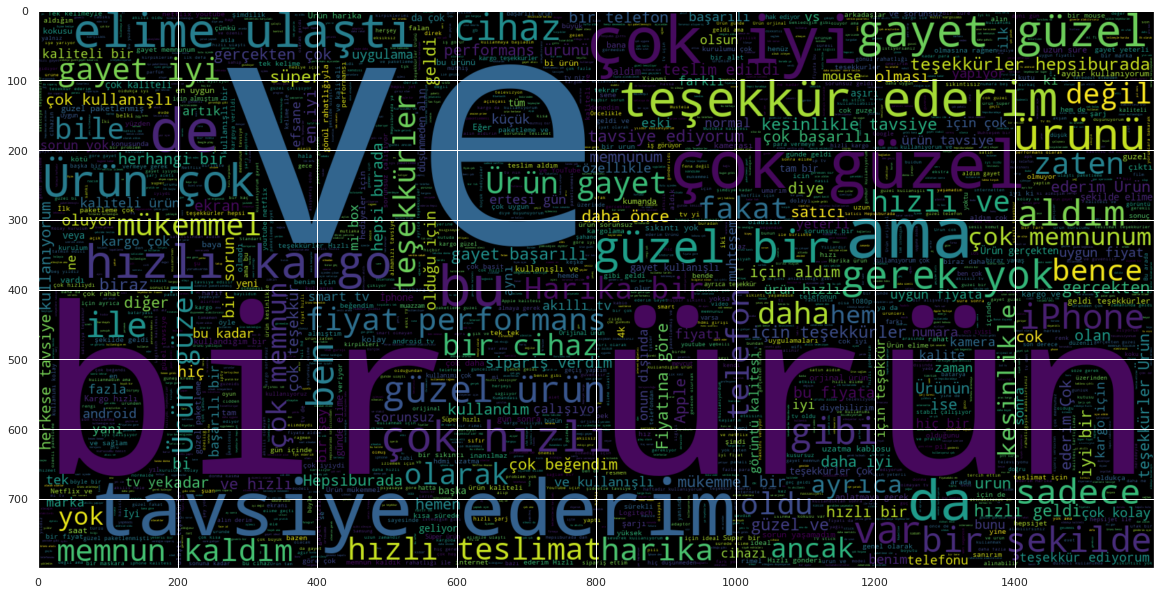

In [91]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) # Positive Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.sentiment == 1].yorum))
plt.imshow(wc , interpolation = 'bilinear')

# Yeni Bölüm

In [92]:
#bert

In [93]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [94]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)


In [95]:
text_test = ['gayet güzel bir ürün']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  5637  3388 19739 12638 12170  2099 24471  4609   102     0     0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [96]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)


In [97]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [98]:
classifier_model = build_classifier_model()


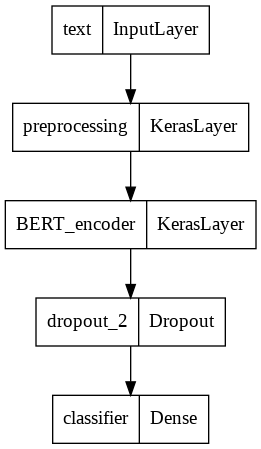

In [99]:
tf.keras.utils.plot_model(classifier_model)


In [100]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [106]:
epochs = 2
steps_per_epoch = 625 #tf.data.experimental.cardinality(train_data).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [107]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [108]:
X = data['yorum']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.yorum,data.sentiment, test_size=0.2, random_state=1)

In [109]:


X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=1) # 0.25 x 0.8 = 0.2


print('Number of reviews in the total set : {}'.format(len(X)))
print('Number of reviews in the training set : {}'.format(len(X_train)))
print('Number of reviews in the validation set : {}'.format(len(X_val)))
print('Number of reviews in the testing set : {}'.format(len(X_test)))

Number of reviews in the total set : 20000
Number of reviews in the training set : 12800
Number of reviews in the validation set : 3200
Number of reviews in the testing set : 4000


In [110]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(X_train, y_train,
                               validation_data=(X_val, y_val),
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/2
400/400 [==============================] - 181s 443ms/step - loss: 0.1989 - binary_accuracy: 0.9215 - val_loss: 0.1841 - val_binary_accuracy: 0.9397
Epoch 2/2
400/400 [==============================] - 173s 432ms/step - loss: 0.1620 - binary_accuracy: 0.9398 - val_loss: 0.1578 - val_binary_accuracy: 0.9337


In [111]:

loss, accuracy = classifier_model.evaluate(X_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

125/125 [==============================] - 23s 185ms/step - loss: 0.1818 - binary_accuracy: 0.9218
Loss: 0.1818363219499588
Accuracy: 0.921750009059906


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


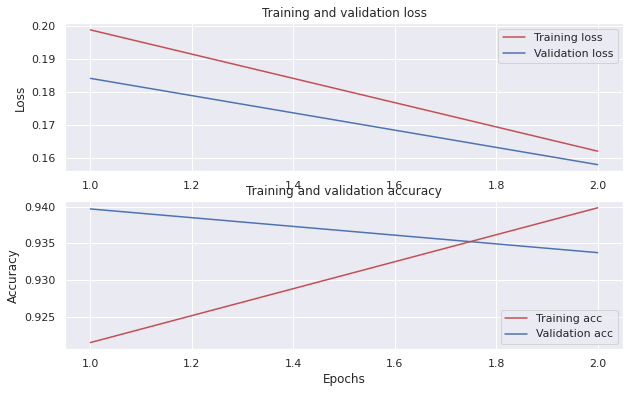

In [112]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [113]:
dataset_name = 'hepsiburada_2'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./hepsiburada_2_bert/assets


INFO:tensorflow:Assets written to: ./hepsiburada_2_bert/assets


In [114]:
reloaded_model = tf.saved_model.load(saved_model_path)


In [115]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'çok güzel bir ürün herkese tavsiye ederim',  # this is the same sentence tried earlier
    'çok başarılı bir ürün',
    'berbat hiç güzel değil ',
    'göründüğü gibi değil iade edicem ',
    'harika ötesi'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: çok güzel bir ürün herkese tavsiye ederim : score: 0.997353
input: çok başarılı bir ürün          : score: 0.990087
input: berbat hiç güzel değil         : score: 0.175615
input: göründüğü gibi değil iade edicem  : score: 0.056859
input: harika ötesi                   : score: 0.998133

Results from the model in memory:
input: çok güzel bir ürün herkese tavsiye ederim : score: 0.997353
input: çok başarılı bir ürün          : score: 0.990087
input: berbat hiç güzel değil         : score: 0.175615
input: göründüğü gibi değil iade edicem  : score: 0.056859
input: harika ötesi                   : score: 0.998133

